




# Projet Fil Rouge 2023 : Reconnaissance de commandes audio


**Noms : Colin - Grivet**

**Prénoms : Rémi - Florian**

**Nom du binôme : Floppy et Rémimi** 




Ces 12 séances de TP vont vous permettre de tester l'algorithme de programmation dynamique vu en CTD puis de réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).

<img src="files/DroneJS" width="600" height="500"  >



Ces séances se décomposent en ces parties : 
- Partie I : Prétraitement des données 
- Partie II : Sélection de variables et pénalisation
- Partie III : Classification par méthodes à noyau 
- Partie IV : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie V : Classification par réseaux de neurones




In [75]:
import re
import glob
import torch
import librosa
import numpy as np
import pandas as pd
from scipy import signal
from scipy.fft import fft
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.svm import SVC, NuSVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split, cross_val_score

# Preprocessing

Sur l'espace moodle, vous trouverez un dossier d'enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05) pour quelques commandes. 


In [2]:
data = [] 
label = [] 
genres = []
min_duration = None
words = ['avance','recule','tournegauche']
list_genres = ['M', 'F']

for file_name in glob.glob('FichierTest/*.wav'):
    record = librosa.load(file_name)[0]
    data.append(record)
    # Computation of the minimal size of recordings
    if min_duration is None or record.shape[0] < min_duration:
        min_duration = record.shape[0] 
    
    # Creation of the vector of label
    for i, word in enumerate(words):
      if re.search(word, file_name):
        label.append(i)

    # Creation of the vector of label
    for i, genre in enumerate(list_genres):
      if re.search(genre, file_name[12:]):# 12 is for ignoring "FichierTest/"
        genres.append(genre)

fs = librosa.load(file_name)[1] # Sampling frequency
genres = np.array(genres)
print(f'The smallest record contains {min_duration} samples, and the sample frequency is {fs} Hz')


The smallest record contains 18522 samples, and the sample frequency is 22050 Hz


### We trim the recordings to isolate the word and have identical durations
The smallest record contains 18 522 samples. We are going to cut all recordings to be of this size.

In [3]:

def trim(record):
    half_duration = 18522//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]
    
    # Finally, we trim the recording around the barycenter 
    return record[barycenter-half_duration:barycenter+half_duration]

In [4]:
X = np.empty((len(data),min_duration))
for i in range(len(data)):
    X[i,:] = trim(data[i])

y = np.array(label)
print(f'Shape of inputs X is{X.shape} and size of targets class is {y.shape}')

Shape of inputs X is(54, 18522) and size of targets class is (54,)


### Spectral representation



1. Apply a Fourrier transform on the signals in $X$ using the function fft of scipy. Explain why the resulting dimension is too large to apply logistic regression.

<font color="green" size=4> Réponse 1 : On a seulement 54 échantillons de longueur 18522.  
Il est impossible de fit un modèle avec 54 obsvervation pour décrire 18522 variables. (18522 > 54)  
Il faut donc réduire la dimension. </font>

In [5]:
# 1
Xchapeau = fft(X)
print(Xchapeau.shape)

(54, 18522)


2. Let $\hat{X}$ be the fourier transform of $X$. Apply a PCA on $|\hat{X}|$ and plot the total explained variance in function of the numer of components.

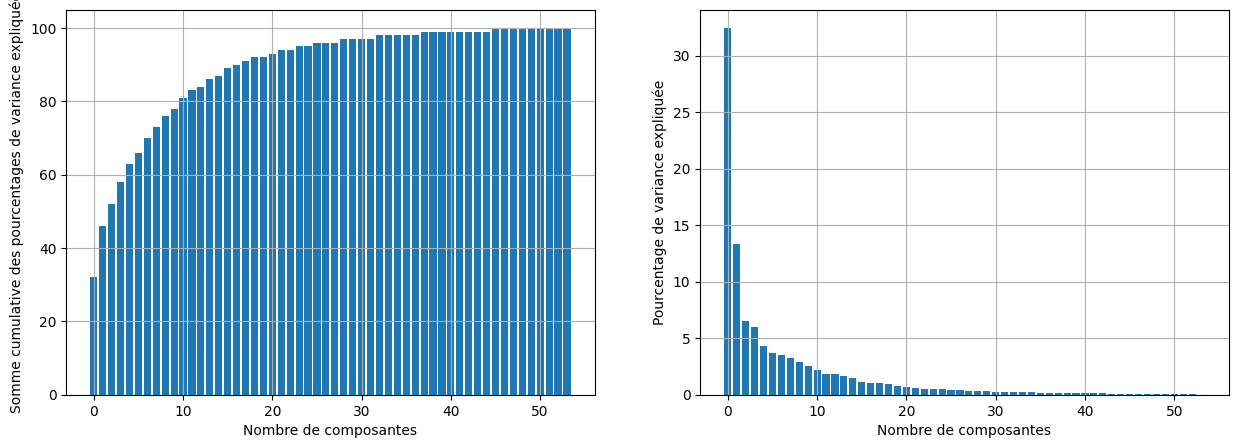

(54, 54)


In [6]:
# 2
pca=PCA()
X_reduit = pca.fit_transform(abs(Xchapeau))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(range(len(pca.explained_variance_ratio_)), np.round(np.cumsum(pca.explained_variance_ratio_) * 100))
ax[0].set_xlabel('Nombre de composantes')
ax[0].set_ylabel('Somme cumulative des pourcentages de variance expliquée')
ax[0].grid()
ax[1].bar(range(len(pca.explained_variance_ratio_)), 100*pca.explained_variance_ratio_)
ax[1].set_xlabel('Nombre de composantes')
ax[1].set_ylabel('Pourcentage de variance expliquée')
ax[1].grid()
plt.show()
print(X_reduit.shape)

<font color="green" size=4> Réponse 2 : On a bien une dimension de 54 avec 54 variables. On peut donc appliquer une régression logistique. </font>

3. Apply a Short Term Fourier Transform on $X$. What are the dimension of stft $\hat{X}[t,f]$?  
La dimension de $\hat{X}[t,f]$ est (127, 147).

4. Make 2 subplots (3x3) of the stft (as images with function .imshow()) with three instances of each words, one for male and one for female 

(127, 147)


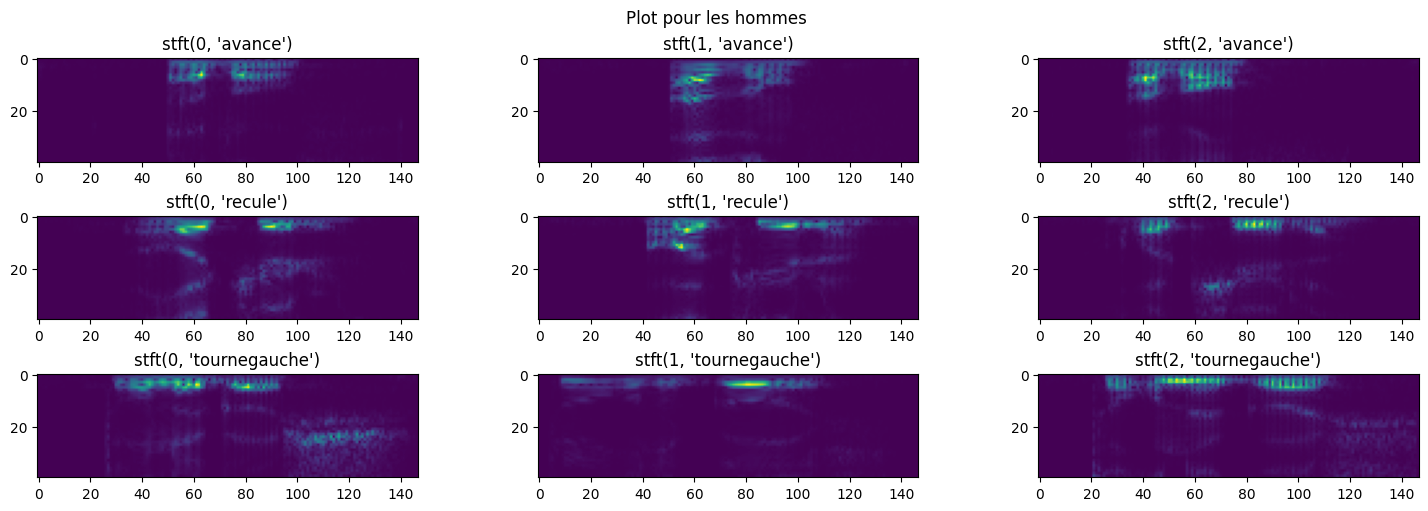

In [7]:
nperseg = 253

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
plt.suptitle("Plot pour les hommes")
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'M')][instance]
        f, t, Zxx = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxx[:40]))
        axs[i,instance].set_title(f'stft{instance,word}')

        
print(Zxx.shape)
plt.show()

(127, 147)


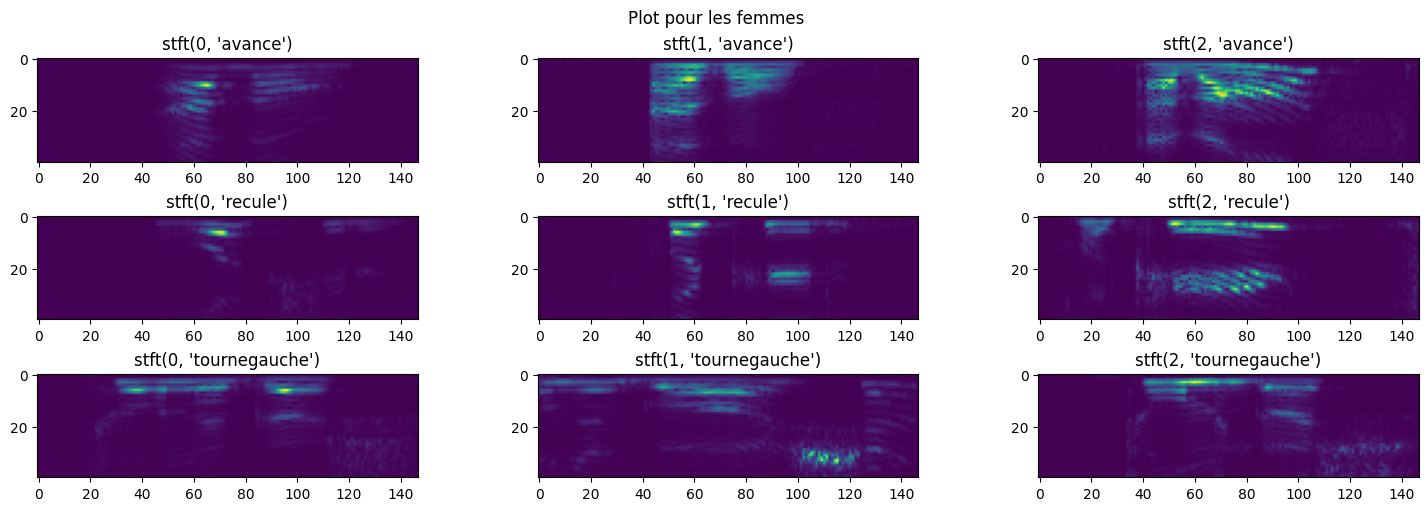

In [8]:
nperseg = 253

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
plt.suptitle("Plot pour les femmes")
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'F')][instance]
        f, t, Zxx = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxx[:40]))
        axs[i,instance].set_title(f'stft{instance,word}')

        
print(Zxx.shape)
plt.show()

La dimension de stft $\hat{X}[t,f]$ est de 127 par 147.

#### Now we will build sklearn transformers to extract features

Create a class STFT in the same spirit as FFT. 
Add a first argument to choose between returning different statistics (mean, quantile, max...) along time such that each signal. Add a second argument that gives the maximum frequency index 

In [9]:
# Fast Fourier Transform
class FFT(BaseEstimator, TransformerMixin):
    def __init__(self, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation        
        return np.absolute(fft(X)[:self.idx_frequence_max])

In [10]:
# Short Term Fourier Transform
class STFT(BaseEstimator, TransformerMixin):
    def __init__(self, stat:str="mean", idx_frequence_max:int = 40):
        """" 
        stat : str : 'mean', 'max', 'min', 'quantile', 'sum'
        idx_frequence_max : int : > 0 and < len(f)
        """
        self.stat = stat
        self.idx_frequence_max = idx_frequence_max
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation  
        f, t, mat = signal.stft(X)
        if self.idx_frequence_max < len(f) :
            mat = mat[:, :self.idx_frequence_max, :]
        else :
            print("Warning, idx_frequence_max higher than len(f)")
        mat = np.absolute(mat)
        if self.stat == "mean" :
            return np.mean(mat, axis=2)
        if self.stat == "max" :
            return np.max(mat, axis=2)
        if self.stat == "min" : 
            return np.min(mat, axis=2)
        if self.stat == "quantile":
            return np.quantile(mat, axis=2)
        if self.stat == "sum":
            return np.sum(mat, axis=2)
        else:
            raise "stat must be reinitialized. Check the STFT class doc."

In [11]:
# TEST
test_stft = STFT("mean", 40)
result_test_stft = test_stft.fit_transform(X)
print(result_test_stft.shape)

(54, 40)


On a un résultat aux bonnes dimensions donc ok.

Fonction de création de courbe ROC récupérée sur Internet :

In [12]:
def ROC(X_test,y_test, classes, y_proba, titre="Courbe ROC") :
    roc_auc_ovr = {}
    size_legend = 6
    for i in range(len(classes)):
        # Gets the class
        c = classes[i]
        # Prepares an auxiliar dataframe to help with the plots
        df_aux = pd.DataFrame(X_test.copy())
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = y_proba[:, i]
        df_aux = df_aux.reset_index(drop = True)
        
        # Calculates the ROC Coordinates and plots the ROC Curves
        nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = metrics.roc_curve(df_aux['class'], df_aux['prob'])
        # tpr, fpr, thresholds = metrics.roc_curve(df_aux['class'], df_aux['prob'])
        roc_auc_ovr[c] = metrics.roc_auc_score(df_aux['class'], df_aux['prob'])
        plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label = f"Class: {int(c)} : AUC = {round(roc_auc_ovr[c], 2)}")    
        plt.plot(nn_fpr_keras, nn_fpr_keras, c = 'gray')
        
    plt.legend(fontsize = size_legend)
    plt.title(titre) # fontsize = size_legend+2)
    plt.xlabel("False Positive") # fontsize = size_legend+1)
    plt.ylabel("True Positive") # fontsize = size_legend+1)

# Partie I : Sélection de modèles et pénalisation

### 1. Multiclass regression


Apply a **multiclass regression** model.

We model the probabilities by the following form :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } {1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
For all $j$ in $\{ 1,2, \dots , K-1 \}$.

### Objective

Try to apply a logistic regression with **Leave one out Cross validation** on :

1. The first PCA components of FFT (try multiple "n_compenents")
2. Different statistics and maximum frequency of the STFT
3. The same as before with scaling

In each situations try different regularization coefficient C.

To simplify use the **pipeline** function of sklearn. You can also use the function **GridSearchCV** with cv = X.shape[0] to vary the parameters of preprocessing and logistic regression. You can acess to all results with "cv_results_"



In [13]:
loo = LeaveOneOut()

In [14]:
# # Cette cellule a été compilé en guise de test et après 30min d'exécution, les résultats commentés plus bas ont été trouvé
# loo = LeaveOneOut()
# # 1
# pipe = Pipeline([("STFT", STFT()), ("Regression", LogisticRegression())]) 
# param_grid = {"STFT__stat":["mean", "max"], 
#               "STFT__idx_frequence_max":[10, 40, 100],
#               "Regression__multi_class":["multinomial"], 
#               "Regression__solver":["lbfgs", "saga", "sag", "newton-cg"], 
#               "Regression__C":[1e-3, 0.1, 0.5, 1, 5, 10], 
#               "Regression__max_iter":[1e4], 
#               "Regression__penalty": ['l1', 'l2', 'elasticnet', 'none']}

# grid_search = GridSearchCV(pipe, param_grid, cv=loo)
# grid_search.fit(X, y)
# print(grid_search.cv_results_)

# print(grid_search.best_params_)
# print(grid_search.best_estimator_)
# print(grid_search.best_index_)
# print(grid_search.best_score_)


# # {'mean_fit_time': array([0.02974204, 0.03192858, 0.02955161, 0.02925937, 0.0328796 ,
# #        0.03254271, 0.04250546, 0.04246219, 0.0283347 , 0.03356607,
# #        0.03449516, 0.03034114, 0.03347619, 0.03489866, 0.05033871,
# #        0.04819337, 0.02949127, 0.02979336, 0.03099916, 0.03116077,
# #        0.03451501, 0.03478535, 0.04493025, 0.04666333, 0.02909168,
# #        0.02892383, 0.03041574, 0.031631  , 0.03268443, 0.03521953,
# #        0.04475017, 0.04093166, 0.02766705, 0.02808923, 0.02954522,
# #        0.02987508, 0.03289441, 0.03419587, 0.05233806, 0.04808912,
# #        0.03077496, 0.02721557, 0.02903877, 0.03313611, 0.03983524,
# #        0.03291378, 0.04369747, 0.04388504, 0.02712361, 0.02713407,
# #        0.02897927, 0.02902517, 0.03267354, 0.03880586, 0.04857113,
# #        0.04536375, 0.02851699, 0.02899992, 0.03047087, 0.03099518,
# #        0.03329365, 0.03297472, 0.04405812, 0.04414322, 0.02665877,
# #        0.02679541, 0.02843267, 0.02840124, 0.03133728, 0.0313335 ,
# #        0.04085116, 0.04101225, 0.02598909, 0.02604444, 0.02766101,
# #        0.02779478, 0.03114292, 0.031182  , 0.04096716, 0.04104564,
# #        0.02604337, 0.02615665, 0.02774906, 0.02787436, 0.03126643,
# #        0.03127462, 0.04095054, 0.04095431, 0.02599755, 0.02622993,
# #        0.02773511, 0.02789127, 0.03115992, 0.03127161, 0.04103365,
# #        0.04109668, 0.07092329, 0.07657389, 0.0442314 , 0.04564688,
# #        0.04290069, 0.03951233, 0.05500178, 0.04844084, 0.11570361,
# #        0.11041393, 0.16295436, 0.15954251, 0.26025346, 0.21751716,
# #        0.53834454, 0.39958923, 0.10213692, 0.10126747, 0.14377567,
# #        0.1393372 , 0.21428082, 0.18224785, 0.42331451, 0.31208517,
# #        0.05032346, 0.04473784, 0.04645407, 0.044994  , 0.04380317,
# # ...
# #        450, 449, 448, 447, 470, 446, 456, 457, 115, 157,   1, 181,   1,
# #         85,  61,  25, 157,  85, 115, 115,  85,  61, 115,   1, 157,  85,
# #        115, 115,  25,  61,  25,   1,  85, 115,  61, 187,  25, 157,  25,
# #         25], dtype=int32)}

# # {'Regression__C': 0.001, 'Regression__max_iter': 10000.0, 'Regression__multi_class': 'multinomial', 'Regression__penalty': 'none', 'Regression__solver': 'lbfgs', 'STFT__idx_frequence_max': 20, 'STFT__stat': 'mean'}
# # Pipeline(steps=[('STFT', STFT(idx_frequence_max=20)),
# #                 ('Regression',
# #                  LogisticRegression(C=0.001, max_iter=10000.0,
# #                                     multi_class='multinomial',
# #                                     penalty='none'))])
# # 98
# # 0.8333333333333334

**Dans la cellule ci-dessus nous avions vu que la meilleure pénalité était "none". Ainsi, on a pas besoin de faire varier C car ce paramètre n'est pas pris en compte lorsque la pénalité est "none". C'est un gain de temps considérable !** 

In [15]:
def grid_search(pipe, param_grid) :
    gs = GridSearchCV(pipe, param_grid, cv=loo, verbose=1, n_jobs=-1)
    gs.fit(X, y)
    return gs

La cellule ci-dessous prend 20 secondes à s'exécuter

In [16]:
# 1 PCA sur la FFT
param_grid_regression = {"Regression__multi_class":["multinomial"], 
                         "Regression__solver":["lbfgs", "saga", "sag", "newton-cg"], 
                         #"Regression__C":np.logspace(-5, 5, 10),  
                         "Regression__max_iter":[1e4], 
                         "Regression__penalty": ['none']}

pipe_1_LR = Pipeline([("FFT", FFT()), ("PCA", PCA()), ("Regression", LogisticRegression())]) 
param_grid_1_LR = {"PCA__n_components":[1, 10, 25, 54], **param_grid_regression}

gs_pipe_1_LR = grid_search(pipe_1_LR, param_grid_1_LR)

Fitting 54 folds for each of 16 candidates, totalling 864 fits


/home/florian/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
216 fits failed out of a total of 864.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "/home/florian/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/florian/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/florian/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  F

La cellule ci-dessous prend 55 secondes à s'exéctuer

In [17]:
# 2 STFT
pipe_2_LR = Pipeline([("STFT", STFT()), ("Regression", LogisticRegression())]) 
param_grid_2_LR = {"STFT__stat":["mean", "max", "min"],
                   "STFT__idx_frequence_max":[10, 20, 40, 100],
                   **param_grid_regression}

gs_pipe_2_LR = grid_search(pipe_2_LR, param_grid_2_LR)

Fitting 54 folds for each of 48 candidates, totalling 2592 fits


/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:35

La cellule ci-dessous prend 80 secondes à s'exécuter

In [18]:
# 3 Même chose que pour 1 et 2 mais en rajoutant le scaling des données au départ
pipe_31_LR = Pipeline([("Scaler", StandardScaler()), ("FFT", FFT()), ("PCA", PCA()), ("Regression", LogisticRegression())]) 
param_grid_31_LR = {**param_grid_1_LR}

gs_pipe31_LR = grid_search(pipe_31_LR, param_grid_31_LR)

pipe_32_LR = Pipeline([("Scaler", StandardScaler()), ("STFT", STFT()), ("Regression", LogisticRegression())]) 
param_grid_32_LR = {**param_grid_2_LR}

gs_pipe32_LR = grid_search(pipe_32_LR, param_grid_32_LR)


Fitting 54 folds for each of 16 candidates, totalling 864 fits


/home/florian/.local/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/florian/.local/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/florian/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
216 fits failed out of a total of 864.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "/home/florian/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 

Fitting 54 folds for each of 48 candidates, totalling 2592 fits


/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

In [19]:
# Affichage des résultats
all_gs = [gs_pipe_1_LR, gs_pipe_2_LR, gs_pipe31_LR, gs_pipe32_LR]
for gs in all_gs :
    print("Paramètres :", gs.best_params_)
    print("Pipeline :", gs.best_estimator_)
    print("Score de précision :", round(gs.best_score_, 4)*100, "%\n")

Paramètres : {'PCA__n_components': 25, 'Regression__max_iter': 10000.0, 'Regression__multi_class': 'multinomial', 'Regression__penalty': 'none', 'Regression__solver': 'lbfgs'}
Pipeline : Pipeline(steps=[('FFT', FFT()), ('PCA', PCA(n_components=25)),
                ('Regression',
                 LogisticRegression(max_iter=10000.0, multi_class='multinomial',
                                    penalty='none'))])
Score de précision : 75.92999999999999 %

Paramètres : {'Regression__max_iter': 10000.0, 'Regression__multi_class': 'multinomial', 'Regression__penalty': 'none', 'Regression__solver': 'lbfgs', 'STFT__idx_frequence_max': 20, 'STFT__stat': 'mean'}
Pipeline : Pipeline(steps=[('STFT', STFT(idx_frequence_max=20)),
                ('Regression',
                 LogisticRegression(max_iter=10000.0, multi_class='multinomial',
                                    penalty='none'))])
Score de précision : 83.33 %

Paramètres : {'PCA__n_components': 25, 'Regression__max_iter': 10000.0, 'Re

### Les paramètre optimaux qui donnent un score de précision de 88.89 % sont :
    - Scaler(),  
    - STFT(idx_frequence_max=100),  
    - LogisticRegression(C=0.001, max_iter=10000.0, multi_class='multinomial', penalty='none')

###  Evaluation des résultats 

Evaluer le résultat par matrice de confusion et pourcentage de bonne classification.

*Conseil :* Pensez à mettre une fonction pour afficher la matrice de confusion

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
def liste_to_one_hot(liste:list, nb_classes:int=3) :
    n_ligne = len(liste)
    tableau = np.array(liste)
    matrice = np.zeros((n_ligne, nb_classes))
    matrice[np.arange(n_ligne), tableau] = 1

    return matrice

def model_to_roc(model, X_train, y_train, X_test, y_test, classes=np.array([0, 1, 2]), titre="Courbe ROC") :
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    y_proba = liste_to_one_hot(prediction, len(classes))
    ROC(X_test, y_test, classes, y_proba, titre)

def gs_to_roc(gs, X_train, y_train, X_test, y_test, classes=np.array([0, 1, 2]), titre="Courbe ROC") :
    best_model = gs.best_estimator_
    model_to_roc(best_model, X_train, y_train, X_test, y_test, classes, titre)
    


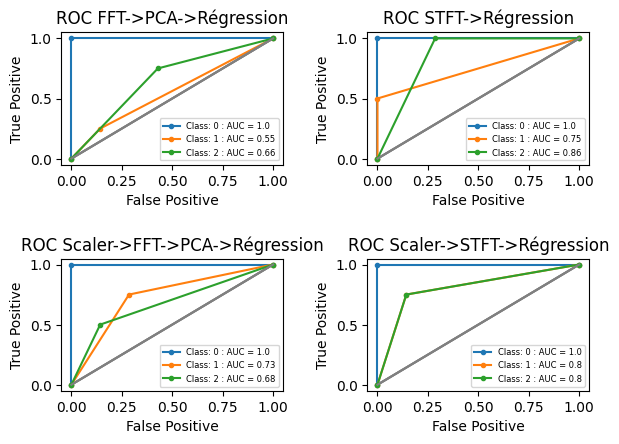

In [56]:
fig = plt.figure()
plt.subplot(2, 2, 1)
gs_to_roc(gs_pipe_1_LR, X_train, y_train, X_test, y_test, titre="ROC FFT->PCA->Régression")
plt.subplot(2, 2, 2)
gs_to_roc(gs_pipe_2_LR, X_train, y_train, X_test, y_test, titre="ROC STFT->Régression")
plt.subplot(2, 2, 3)
gs_to_roc(gs_pipe31_LR, X_train, y_train, X_test, y_test, titre="ROC Scaler->FFT->PCA->Régression")
plt.subplot(2, 2, 4)
gs_to_roc(gs_pipe32_LR, X_train, y_train, X_test, y_test, titre="ROC Scaler->STFT->Régression")
fig.tight_layout(pad=2)
plt.show()

Score de précision : 81.82000000000001 %


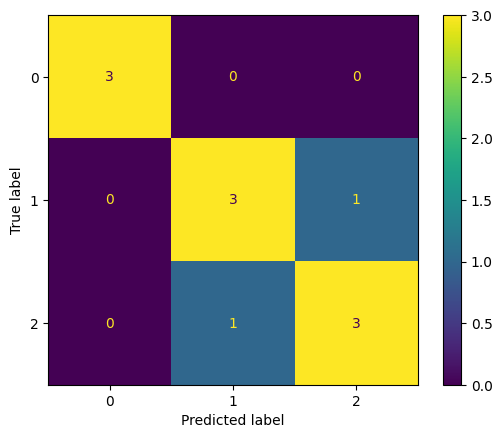

In [52]:
# Evaluation des résultats par matrices de confusion 

best_model = sorted(all_gs, key=lambda x : x.best_score_ , reverse=True)[0].best_estimator_

best_model.fit(X_train, y_train)

y_prediction = best_model.predict(X_test)

confusion_matrix(y_test, y_prediction)
cm = confusion_matrix(y_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print("Score de précision :", round(accuracy_score(y_test, y_prediction), 4)*100, "%")


# Partie II : Classification par méthodes à noyau

**Rappel** Les méthodes à noyau consistent à plonger les données dans un espace de dimension de Hilbert $\mathcal{H}$ ou les donnés pourront être séparé linéairement. 

**Theorème de Représentation :** La solution du problème de séparation en dimension infinie est contenue dans un sous espace vectoriel de dimension finie de $\mathcal{H}$ 

### 1. Réaliser une classification par SVM à noyau

    1) Varier le noyau
    2) Varier le paramètre de régularisation.


Nous reprenons les meilleurs paramètres de la STFT trouvés précédemment et essayons plusieurs noyau / paramètre de régularisation.  
La cellule ci-dessous met 2 minutes à s'exécuter.

In [57]:
svm_model = Pipeline([("STFT", STFT()), ("svm", SVC())])

svm_parameters = {
    "STFT__stat":["mean"],
    "STFT__idx_frequence_max":[40, 100],
    'svm__kernel': ['linear', 'poly', 'rbf'],
    'svm__C': np.logspace(-2, 5, 6),
    'svm__gamma': np.logspace(-4, 3, 6)
}


# Optimisation des hyperparamètres
clf = grid_search(svm_model, svm_parameters)



Fitting 54 folds for each of 216 candidates, totalling 11664 fits


In [58]:
print(clf.best_params_)
print(clf.best_score_)

{'STFT__idx_frequence_max': 40, 'STFT__stat': 'mean', 'svm__C': 100000.0, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'}
0.8518518518518519


Le meilleur noyau est le noyau minear donc on reprend ce noyau pour le NuSVC + le noyau rbf.  
La cellule ci-dessous met 40 secondes à s'exécuter

In [59]:
nusvm_model = NuSVC()

nusvm_parameters = {
    'nu' : [0.1, 0.5, 0.8],
    'kernel': ['linear', 'rbf'],
    'gamma': np.logspace(-4, 3, 6)
}


# Optimisation des hyperparamètres
clf_nu = grid_search(nusvm_model, nusvm_parameters)

print(clf_nu.best_params_)
print(clf_nu.best_score_)



Fitting 54 folds for each of 36 candidates, totalling 1944 fits


{'gamma': 0.0001, 'kernel': 'linear', 'nu': 0.1}
0.4074074074074074


1. Appliquer une PCA + SVC rbf et créer une fonction qui plot les frontières de décisions
2. Quelle est l'influence de $\gamma$ ? Justifiez
3. Quelle est l'influence de C ?

Le code ci-dessous met 3 minutes 30 secondes pour s'exécuter

In [62]:
pipeline_svm = Pipeline([("PCA", PCA()), ("svm", SVC())]) 
svm_parameters_rbf = {
    'svm__kernel': ['rbf'],
    'svm__C': np.logspace(-2, 5, 8),
    'svm__gamma': np.logspace(-4, 3, 8)
}


# Optimisation des hyperparamètres
clf_svm_rbf = grid_search(pipeline_svm, svm_parameters_rbf)

print(clf_svm_rbf.best_params_)
print(clf_svm_rbf.best_score_)

Fitting 54 folds for each of 64 candidates, totalling 3456 fits


{'svm__C': 1000.0, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
0.3888888888888889


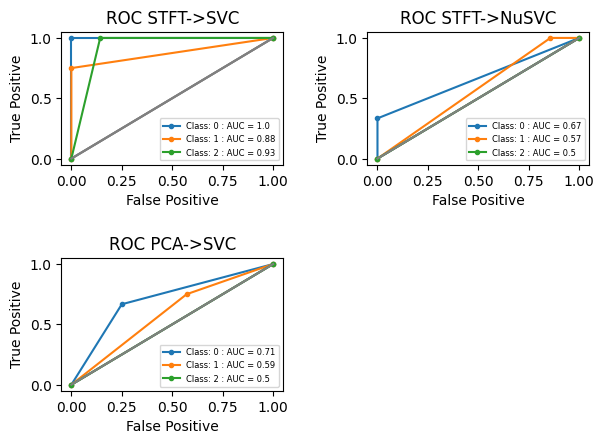

In [63]:
fig = plt.figure()
plt.subplot(2, 2, 1)
gs_to_roc(clf, X_train, y_train, X_test, y_test, titre="ROC STFT->SVC")
plt.subplot(2, 2, 2)
gs_to_roc(clf_nu, X_train, y_train, X_test, y_test, titre="ROC STFT->NuSVC")
plt.subplot(2, 2, 3)
gs_to_roc(clf_svm_rbf, X_train, y_train, X_test, y_test, titre="ROC PCA->SVC")
fig.tight_layout(pad=2)
plt.show()

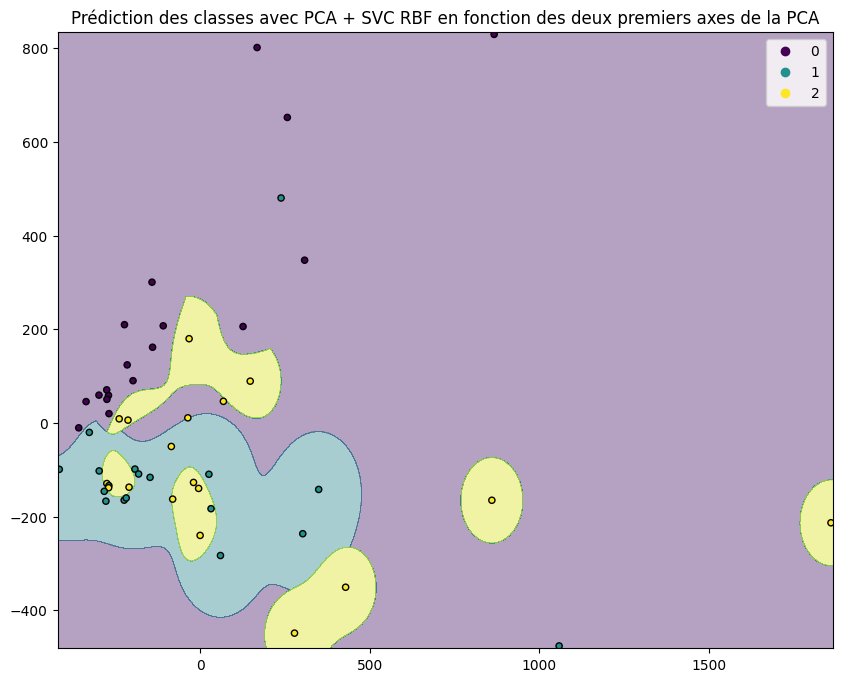

In [35]:
X_train_reduit, X_test_reduit, y_train_reduit, y_test_reduit = train_test_split(X_reduit[:,0:2], y, test_size=0.2)

clf_test = SVC(C=1000, gamma=0.0001, kernel='rbf')
clf_test.fit(X_train_reduit, y_train_reduit)

x_min, x_max = X_reduit[:, 0].min() - 5, X_reduit[:, 0].max() + 5
y_min, y_max = X_reduit[:, 1].min() - 5, X_reduit[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

# Prédire les classes pour chaque point de la grille
Z = clf_test.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Tracé des frontières de décision
f, ax = plt.subplots(1, 1, sharex="col", sharey="row", figsize=(10, 8))
ax.contourf(xx, yy, Z, alpha=0.4)
scatter = ax.scatter(X_reduit[:, 0], X_reduit[:, 1], c=y, s=20, edgecolor="k")
ax.set_title("Prédiction des classes avec PCA + SVC RBF en fonction des deux premiers axes de la PCA")
ax.legend(handles=scatter.legend_elements()[0], labels=scatter.legend_elements()[1])
plt.show()


# Partie III : Apprentissage par ensemble 

## 1. Bootstrap Aggregation : Bagging

Boostrap consists in creating multiple data sets as follows. Suppose our
original data set consists of $N$ data points $X = \{x_1,..., x_N \}$. We can create a new
data set $X_B$ by drawing $N$ points at random from X, with replacement, so that some
points in $X$ may be replicated in $X_B$, whereas other points in $X$ may be absent from
$X_B$. This process can be repeated $L$ times to generate $L$ data sets each of size $N$ and
each obtained by sampling from the original data set $X$.

Consider a binary classification problem in which we are trying to predict the class, and suppose we generate $M$ bootstrap data sets and then use each to train a separate copy $y_m(x)$ of a classifier where $m = 1,...,M$. The committee prediction is given by voting with all $M$ models.

1. First you will transform $y$ in $y^1$ as follow
if $y = 1$, then $y^1 = 1$
if $y = 0$ or $y = 2$, then $y^1 = 0$
Now we can apply binary classification

2. Code from scratch the Bagging of Decision trees with *max_depth = 2* only and compare the accuracy of the bagging model with the mean accuracy of the models and conclude. with *max_depth = 2* only and compare the accuracy of the bagging model with the mean accuracy of the models and conclude. (the bootstrap is done on the training set with np.random.choice, and use $M=100$)

3. Apply Random Forest on the initial classification problem (3 classes) and adjust the hyperparameters. Is random Forest a Bagging model?



In [29]:
### 1. create y1
y1 = (y==1).astype(int)

In [39]:
### 2.
np.random.seed(42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y1,test_size=0.4, random_state=42)
np.random.seed(seed=42)

In [40]:
# Bagging of Decision trees
M = 100
Ntrain = len(y_train2)
scores = np.zeros(M)
results = np.zeros((M, len(y_test2)))


for m in range(M) :
    indicesModel = np.random.randint(0, Ntrain, Ntrain)
    Xb, yb = X_train2[indicesModel], y_train2[indicesModel]
    treeb = Pipeline([("STFT", STFT()), ("tree", DecisionTreeClassifier(max_depth=2))]) 
    treeb.fit(Xb, yb)
    scores[m] = treeb.score(X_test2, y_test2)
    results[m] = treeb.predict(X_test2)

In [41]:
# Predict bagging
predictions = (np.sum(results, axis=0) >= (M/2)).astype(int)
score_bagging = np.mean(predictions == y_test2)

In [42]:
# Comparaison de l'accuracy entre les deux modèles
print("Moyenne des scores de chaque modèle :", np.mean(scores))
print("Accuracy du modèle de bagging :",score_bagging)

Moyenne des scores de chaque modèle : 0.7177272727272727
Accuracy du modèle de bagging : 0.6818181818181818


2\) En moyenne, le modèle de bagging est moins précis que les modèles qui le compose.

In [43]:
# 3
foret = Pipeline([("STFT", STFT()), ("foret", RandomForestClassifier(n_estimators=M, max_depth=2))])
foret.fit(X_train2, y_train2)
print(foret.score(X_test2, y_test2))

0.8181818181818182


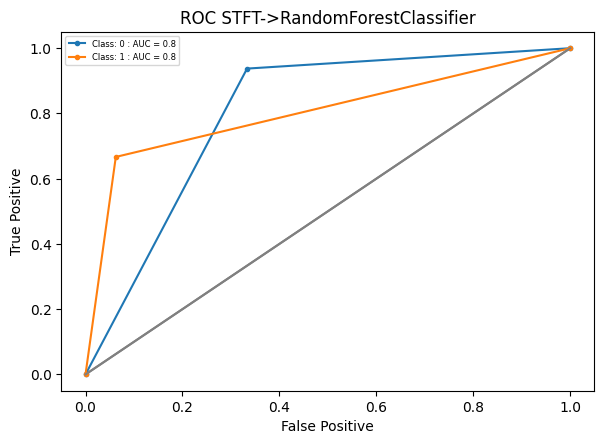

In [54]:
# Courbe ROC
fig = plt.figure()
model_to_roc(foret, X_train2, y_train2, X_test2, y_test2, classes=np.array([0, 1]), titre="ROC STFT->RandomForestClassifier")
fig.tight_layout(pad=2)
plt.show()

3\) Oui, le Random Forest est un modèle de Bagging.

## 2. Adaptative boosting : AdaBoost

Here is the algorithm Adaboost

1. Initialize the data weighting coefficients ${w_n}$ by setting $w_n^{(1)} = 1/N$ for $n = 1,...,N$.
2. For $m = 1,...,M$:
    
    **(a)** Fit a classifier $y_m(x)$ to the training data by minimizing the weighted
error function
    
    $J_m = \sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}$

    where $I(y_m(x)\neq t_n)$ is the indicator function and equals $1$ when $y_m(x_n) 	\neq t_n$ and $0$ otherwise

    **(b)** Evaluate the quantities

    $\epsilon_m = \frac{\sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}}{\sum_{n=1}^N{w_n^{(m)}}}$

    and then use these to evaluate

    $\alpha_m = \textit{ln}\left({\frac{1-\epsilon_m}{\epsilon_m}}\right)$

    **(c)** Update the data weighting coefficients
    
    $w_n^{(m+1)} = w_n^{(m)} \textit{exp}\left({\alpha_m I(y_m(x_n) \neq t_n)}\right)$

3. Make predictions using the final model, which is given by

    $Y_M(x) = \text{sign}\left(\sum_{m=1}^M {\alpha_m y_m(x)}\right)$


**Question 1 :** Code from scratch the Adaboost algorithm in the same configuration as Bagging in the previous section. Use the sklearn decision tree classifier and its argument *sample_weight*. Compare its performances with Bagging.


In [55]:
# Boosting en série / bagging en parallèle (Boosting loi du plus fort et bagging loi du grand nombre) 
# Boosting pour des prédicteurs faibles
y2 = (y1 * 2)-1
X_STFT = STFT().fit_transform(X, y)
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(X_STFT,y2,test_size=0.4, random_state=42)

In [56]:
# 1
N_boost = len(y_train_boost)
w_boost = np.ones(N_boost) / N_boost

# 2
M_boost = 100
alphas_boost = np.zeros(M_boost)
forest_boost = []

for m in range(M_boost) :
    # a
    tree = DecisionTreeClassifier(max_depth=1)
    tree.fit(X_train_boost, y_train_boost, w_boost)
    # b
    indicatrice = (tree.predict(X_train_boost) != y_train_boost).astype(int)
    epsilon_boost = np.sum(w_boost * indicatrice) / np.sum(w_boost)
    alpha = np.log((1-epsilon_boost) / epsilon_boost)
    alphas_boost[m] = alpha
    forest_boost.append(tree)
    # c 
    w_boost = w_boost * np.exp(alpha*indicatrice)

# 3
predict_boost = np.zeros((M_boost, len(y_test_boost)))
for i in range(M_boost) :
    predict_boost[i] = forest_boost[i].predict(X_test_boost) * alphas_boost[i]

predictions_boost = np.sign(np.sum(predict_boost, axis=0))

score_boost = np.mean((predictions_boost == y_test_boost).astype(int))
print(score_boost)

0.7727272727272727


In [57]:
# Comparaison de l'accuracy entre le bagging et le boosting
print("Accuracy du modèle de boosting :", score_boost)
print("Accuracy du modèle de bagging :",score_bagging)

Accuracy du modèle de boosting : 0.7727272727272727
Accuracy du modèle de bagging : 0.6818181818181818


Le modèle de boosting est plus précis que le modèle de bagging.

**Question 2 :** 
With sklearn library, apply adaboost with decision tree (*max_depth=2*) on the 3-class classification problem. Find good parameters with the leave one out cross validation. Do the same thing with Gradient bossting.
If you have the time, you can test with XGBoost.


In [64]:
adaBoostClassifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=M_boost)
adaBoostClassifier.fit(X_train_boost, y_train_boost)
adaBoostClassifier.score(X_test_boost, y_test_boost)

0.8181818181818182

### Evaluation de la classification

Utiliser la validation croisée pour évaluer les résultats 

In [65]:
scores_boost = cross_val_score(adaBoostClassifier, X_test_boost, y_test_boost)
print(score_boost.mean())

0.7727272727272727


# Partie IV : Neural Network with pytorch

Below we create torch tensor with the shape $(N,B,F)$, where
    
$N$ is the number of recordings in the set (train/test)

$B$ the size of batch, we choose $B=1$ because the dataset is really small

$F$ is the number of features

The tensors are converted to float type

The train set and test set constitute 50% of the initial dataset

**Transform X with your preprocessing**

In [74]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    
preprocessing = Pipeline([("Scaler", StandardScaler()), ("STFT", STFT())]) 

### transform X with your preprocessing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=40)

X_train = preprocessing.fit_transform(X_train, y_train)
X_test = preprocessing.transform(X_test)



X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float().to(device)
X_test = torch.tensor(X_test).reshape((X_test.shape[0],1,-1)).float().to(device)
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0],1,-1)).float().to(device)
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0],1,-1)).float().to(device)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


**Question 1:** : Create a model class (descending from torch.nn.Module). In a first time choose the appropriate architecture and the appropriate loss (the loss appear later) to reproduce logistic regression

Usually a FNN is a succession of blocks (linear -> ReLU). Finally the networks transforms the initial vector into the output $\hat{y} \in \mathbb{R}^3, \hat{y}=(\mathbb{P}(y=0|x),\mathbb{P}(y=1|x),\mathbb{P}(y=2|x))$ where $y$ is the word we want to predict and $x \in \mathbb{R}^{18522}$ is the accoustic signal

    
    

## Régression logistique

In [69]:
print(X_train.shape)

torch.Size([27, 1, 40])


In [70]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear
            torch.nn.Linear(40, 3).to(device) ## 3 sorties
        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return torch.nn.functional.softmax(self.network(xb), 1)

In [71]:
model = NNClassification()
num_epochs = 1000

result_test_loss = []
result_train_loss= []
result_train_predictions = []
result_test_predictions = []

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr)
loss = torch.nn.CrossEntropyLoss() ### What loss do you think is well suited for the classification problem (same as logistic regression)

for epoch in range(num_epochs):

    model.train()
    train_losses = []
    predictions_train = []
    for i in range(X_train.shape[0]):
       ### code the training step (compute loss -> optimization step -> save the loss )
        optimizer.zero_grad()
        sortie = model(X_train[i])
        loss_train = loss(sortie, y_train[i])
        loss_train.backward()
        optimizer.step()
        train_losses.append(loss_train)
        predictions_train.append(torch.argmax(sortie) == torch.argmax(y_train[i]))



        
    model.eval()
    test_losses = []
    predictions_test = []
    for i in range(X_test.shape[0]):
        ### code the eval step  (compute loss -> save the loss )
        sortie = model(X_test[i])
        predictions_test.append(torch.argmax(sortie) == torch.argmax(y_test[i]))
        loss_test = loss(sortie, y_test[i])
        test_losses.append(loss_test)
        
    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append( torch.stack(test_losses).mean().item())
    result_test_predictions.append(100 * torch.stack(predictions_test).sum().item() / len(y_test))
    result_train_predictions.append(100 * torch.stack(predictions_train).sum().item() / len(y_train))



**Question 2:** Plot the train and test loss. What do you observe?

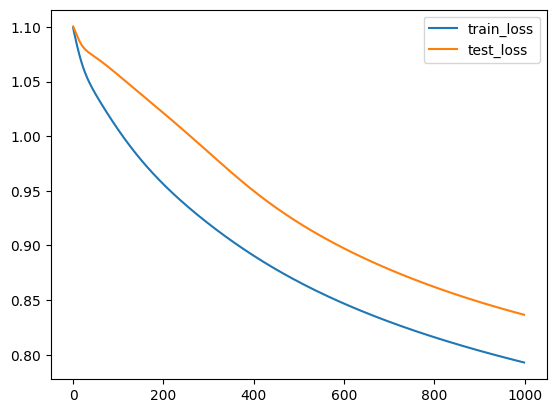

In [72]:
plt.figure()
plt.plot(result_train_loss, label="train_loss")
plt.plot(result_test_loss, label="test_loss")
plt.legend()
plt.show()

On observe que la fonction loss du train et du test 

**Question 3 :** Compute the accuracy.

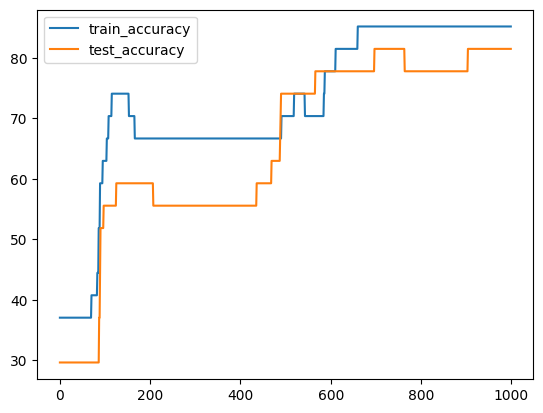

In [17]:
plt.figure()
plt.plot(result_train_predictions, label="train_accuracy")
plt.plot(result_test_predictions, label="test_accuracy")
plt.legend()
plt.show()

In [18]:
print(y_test.shape)

torch.Size([27, 1, 3])


## Autre réseau (pour tester l'overfitting)

**Question 1:** : Create a model class (descending from torch.nn.Module). In a first time choose the appropriate architecture and the appropriate loss (the loss appear later) to reproduce logistic regression

Usually a FNN is a succession of blocks (linear -> ReLU). Finally the networks transforms the initial vector into the output $\hat{y} \in \mathbb{R}^3, \hat{y}=(\mathbb{P}(y=0|x),\mathbb{P}(y=1|x),\mathbb{P}(y=2|x))$ where $y$ is the word we want to predict and $x \in \mathbb{R}^{18522}$ is the accoustic signal

    
    

In [19]:
print(X_train.shape)

torch.Size([27, 1, 40])


In [20]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear
            torch.nn.Linear(40, 200).to(device), ## 3 sorties
            torch.nn.ReLU(),
            torch.nn.Linear(200, 200).to(device),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 3).to(device)
        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return torch.nn.functional.softmax(self.network(xb), 1)

In [21]:
model = NNClassification()
num_epochs = 300

result_test_loss = []
result_train_loss= []
result_train_predictions = []
result_test_predictions = []

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr)
loss = torch.nn.CrossEntropyLoss() ### What loss do you think is well suited for the classification problem (same as logistic regression)

for epoch in range(num_epochs):

    model.train()
    train_losses = []
    predictions_train = []
    for i in range(X_train.shape[0]):
       ### code the training step (compute loss -> optimization step -> save the loss )
        optimizer.zero_grad()
        sortie = model(X_train[i])
        loss_train = loss(sortie, y_train[i])
        loss_train.backward()
        optimizer.step()
        train_losses.append(loss_train)
        predictions_train.append(torch.argmax(sortie) == torch.argmax(y_train[i]))



        
    model.eval()
    test_losses = []
    predictions_test = []
    for i in range(X_test.shape[0]):
        ### code the eval step  (compute loss -> save the loss )
        sortie = model(X_test[i])
        predictions_test.append(torch.argmax(sortie) == torch.argmax(y_test[i]))
        loss_test = loss(sortie, y_test[i])
        test_losses.append(loss_test)
        
    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append( torch.stack(test_losses).mean().item())
    result_test_predictions.append(100 * torch.stack(predictions_test).sum().item() / len(y_test))
    result_train_predictions.append(100 * torch.stack(predictions_train).sum().item() / len(y_train))



**Question 2:** Plot the train and test loss. What do you observe?

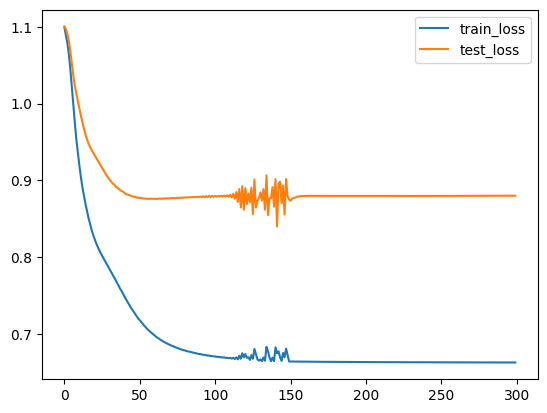

In [22]:
plt.figure()
plt.plot(result_train_loss, label="train_loss")
plt.plot(result_test_loss, label="test_loss")
plt.legend()
plt.show()

On observe que les fonctions loss du train comme du test baissent en fonction du nombre d'epochs, ce qui est très bien. \
La fonction loss du train est en dessous de celle du test, ce qui paraît logique également. \
On apprend bien du train en fonction du nombre d'epochs pour avoir une meilleure prédiction sur les tests.

**Question 3 :** Compute the accuracy.

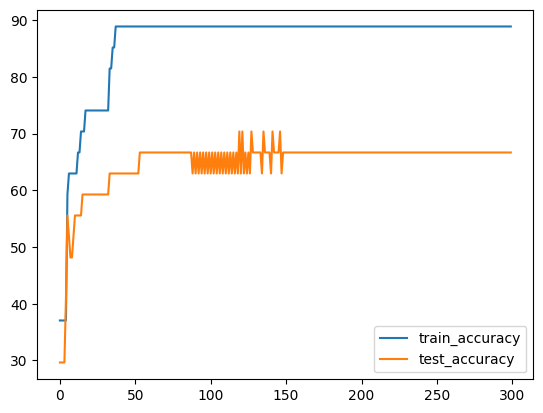

In [23]:
plt.figure()
plt.plot(result_train_predictions, label="train_accuracy")
plt.plot(result_test_predictions, label="test_accuracy")
plt.legend()
plt.show()

**Question 4:** If you encounter overfitting try to regularize your model with Dropout and/or L2/L1 Regularization

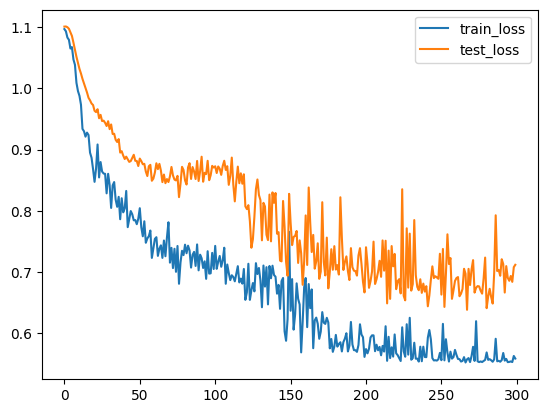

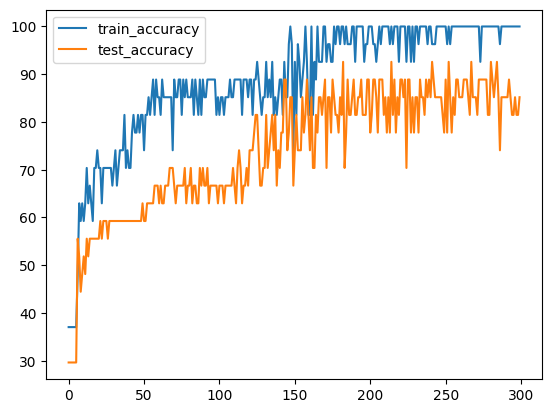

In [24]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear
            torch.nn.Linear(40, 200).to(device), ## 3 sorties
            torch.nn.Dropout(0.4),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 200).to(device),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            torch.nn.Linear(200, 3).to(device)
        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return torch.nn.functional.softmax(self.network(xb), 1)
    

model = NNClassification()
num_epochs = 300

result_test_loss = []
result_train_loss= []
result_train_predictions = []
result_test_predictions = []

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr)
loss = torch.nn.CrossEntropyLoss() ### What loss do you think is well suited for the classification problem (same as logistic regression)

for epoch in range(num_epochs):

    model.train()
    train_losses = []
    predictions_train = []
    for i in range(X_train.shape[0]):
       ### code the training step (compute loss -> optimization step -> save the loss )
        optimizer.zero_grad()
        sortie = model(X_train[i])
        loss_train = loss(sortie, y_train[i])
        loss_train.backward()
        optimizer.step()
        train_losses.append(loss_train)
        predictions_train.append(torch.argmax(sortie) == torch.argmax(y_train[i]))



        
    model.eval()
    test_losses = []
    predictions_test = []
    for i in range(X_test.shape[0]):
        ### code the eval step  (compute loss -> save the loss )
        sortie = model(X_test[i])
        predictions_test.append(torch.argmax(sortie) == torch.argmax(y_test[i]))
        loss_test = loss(sortie, y_test[i])
        test_losses.append(loss_test)
        
    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append( torch.stack(test_losses).mean().item())
    result_test_predictions.append(100 * torch.stack(predictions_test).sum().item() / len(y_test))
    result_train_predictions.append(100 * torch.stack(predictions_train).sum().item() / len(y_train))


plt.figure()
plt.plot(result_train_loss, label="train_loss")
plt.plot(result_test_loss, label="test_loss")
plt.legend()
plt.show()


plt.figure()
plt.plot(result_train_predictions, label="train_accuracy")
plt.plot(result_test_predictions, label="test_accuracy")
plt.legend()
plt.show()

**Question 5(Bonus)** : Create a CNN that takes in input the accoustic signal without preprocessing

In [25]:
print(X_train[0, 0].shape)

torch.Size([40])


In [37]:
def calculate_output_length(length_in, kernel_size, stride=1, padding=0, dilation=1):
    return (length_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

etape1 = calculate_output_length(18522, 4, 3)
etape2 = calculate_output_length(etape1, 3, 2)
etape3 = calculate_output_length(etape2, 4, 3)
# etape4 = calculate_output_length(etape3, 3, 1)
# etape5 = calculate_output_length(etape4, 4, 2)

print(etape1)
print(etape2)
print(etape3)
# print(etape4)
# print(etape5)

6173
3086
1028


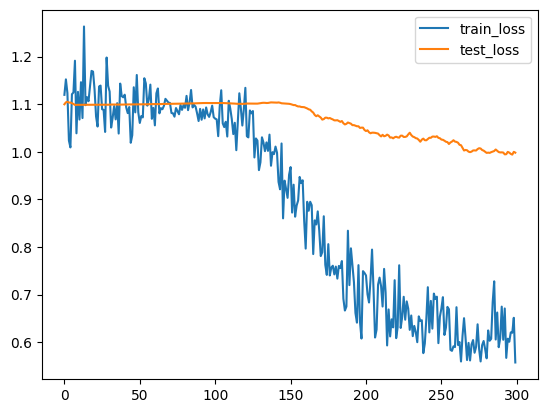

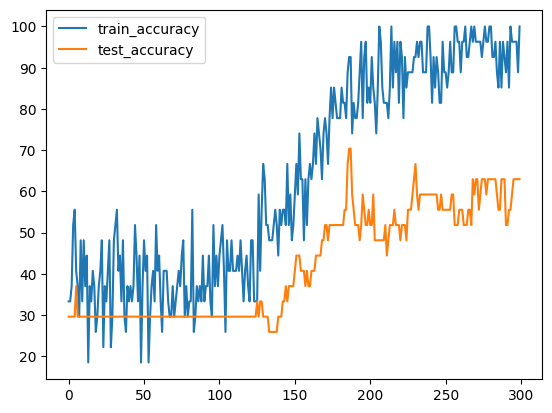

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=40)
X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float().to(device)
X_test = torch.tensor(X_test).reshape((X_test.shape[0],1,-1)).float().to(device)
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0],1,-1)).float().to(device)
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0],1,-1)).float().to(device)

class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear
            torch.nn.Conv1d(1, 20, kernel_size=4, stride=3).to(device), # 20 x 6172
            torch.nn.Dropout(0.8),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=3, stride=2).to(device), # 20 x 3085
            torch.nn.Dropout(0.8),
            torch.nn.ReLU(),
            torch.nn.Conv1d(20, 1, kernel_size=4, stride=3).to(device), # 10 x 1026
            torch.nn.Dropout(0.8),
            torch.nn.ReLU(),
            torch.nn.Linear(1028, 3).to(device) # 1 x 3
        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return torch.nn.functional.softmax(self.network(xb), 1)
    

model = NNClassification()
num_epochs = 300

result_test_loss = []
result_train_loss= []
result_train_predictions = []
result_test_predictions = []

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr)
loss = torch.nn.CrossEntropyLoss() ### What loss do you think is well suited for the classification problem (same as logistic regression)

for epoch in range(num_epochs):

    model.train()
    train_losses = []
    predictions_train = []
    for i in range(X_train.shape[0]):
       ### code the training step (compute loss -> optimization step -> save the loss )
        optimizer.zero_grad()
        sortie = model(X_train[i])
        loss_train = loss(sortie, y_train[i])
        loss_train.backward()
        optimizer.step()
        train_losses.append(loss_train)
        predictions_train.append(torch.argmax(sortie) == torch.argmax(y_train[i]))



        
    model.eval()
    test_losses = []
    predictions_test = []
    for i in range(X_test.shape[0]):
        ### code the eval step  (compute loss -> save the loss )
        sortie = model(X_test[i])
        predictions_test.append(torch.argmax(sortie) == torch.argmax(y_test[i]))
        loss_test = loss(sortie, y_test[i])
        test_losses.append(loss_test)
        
    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append( torch.stack(test_losses).mean().item())
    result_test_predictions.append(100 * torch.stack(predictions_test).sum().item() / len(y_test))
    result_train_predictions.append(100 * torch.stack(predictions_train).sum().item() / len(y_train))


plt.figure()
plt.plot(result_train_loss, label="train_loss")
plt.plot(result_test_loss, label="test_loss")
plt.legend()
plt.show()


plt.figure()
plt.plot(result_train_predictions, label="train_accuracy")
plt.plot(result_test_predictions, label="test_accuracy")
plt.legend()
plt.show()

On a de l'overfitting, ce qui est normal au vu du nombre de données que nous avons en entrée. Faire de l'augmentation de données pourrait permettre de réduire cet overfitting.